In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import colorcet as cc
import os
import re

from scipy import stats
import random

TR=1.3
%matplotlib inline

In [50]:
timelist=np.array(range(20,317))*TR  #exclude the first 20 and last 6 TRs
#used for BOLD processing

excludeSubjects = [] #inaudible
MIN_VARIABILITY = .2 #minimum max-min in dynamic rating
BOLD_Delay=4.5 #seconds
MAX_TIME=4200-1 #the maximum time in 100 msec that can ever appear
RATING_SHIFT=40 #4 second


initialcutoff=60 # cut out the first 60 seconds

rootfolder='path_to_project_root'
projectfolder=rootfolder+'/BOLD/'

#behavioral data
ratingfolder=rootfolder+'/dynamic ratings/'
textFolder=rootfolder+'/Event Boundaries/processed/EB_timestamped_v4_gpt/'

decodedModel='decodedStateSequence.csv'
custom_colors=['crimson','darkorange','olivedrab','dodgerblue','blueviolet']
selectstates=['1','2','3','5','7']

In [40]:
def safeNorm(ratings):
    mediantmp=ratings.median()
    stdtmp=ratings.std()
    ret=ratings.clip(upper=mediantmp+4*stdtmp,lower=mediantmp-4*stdtmp)
    return ((ret-ret.mean())/ret.std())

In [ ]:
participants=pd.read_csv(rootfolder+'/questionnaires.csv')
participants['subid']=participants.apply(lambda r: 'sub-'+str(r['Eprime ID']).zfill(2), axis=1)

In [18]:
decodedTC=pd.read_csv(projectfolder+'hmm/'+decodedModel,index_col=None,dtype={'subid': str})
decodedTC['subid']=decodedTC.apply(lambda r: 'sub-'+r['subid'],axis=1)
decodedTC['newtask']=decodedTC.apply(lambda r: r['task'].replace('ta1','ta').replace('ta2','ta'), axis=1)
decodedTC.loc[:,'time']=list(timelist)*len(decodedTC[['subid','task']].value_counts())
nstate=len(decodedTC['state'].unique())
statelist=[str(i) for i in range(nstate)]

# Continueous analysis

In [34]:
def modifyratings(textDF,ratingvalues,maxExtension=0,usecolumn=None,shift=RATING_SHIFT):
    shifted = ratingvalues.set_axis(ratingvalues.index-shift)
    shifted=pd.concat([shifted,pd.Series(shifted.iloc[-1],index=range(shifted.index[-1]+1,MAX_TIME+1))]) 
    textDF['begin']=np.round(textDF['begin_timestamp']*10).astype(int)
    textDF['end']=np.round(textDF['end_timestamp']*10).astype(int)
    textDF['end']=textDF['end'].clip(upper=MAX_TIME)
    textDF['next']=textDF['begin'].shift(-1).fillna(MAX_TIME).astype(int)
    modifiedRating=pd.Series(np.nan,index=range(MAX_TIME+2))
    for i,r in textDF.iterrows():
        if usecolumn==None:
            startrating=shifted.loc[r['end']]
            endrating=shifted.loc[min(r['next'],r['end']+maxExtension)]
            nextrating=shifted.loc[r['next']]
            steps=r['end']-r['begin']
            modifiedRating.loc[r['begin']:r['end']]=shifted.loc[r['begin']:r['end']].values
            modifiedRating.loc[r['end']:r['next']]=shifted.loc[r['end']:r['next']].values
        else:
            modifiedRating.loc[r['begin']+1:r['end']+1]=r[usecolumn]
            modifiedRating.loc[r['end']+1:r['next']+1]=r[usecolumn]
    return modifiedRating
def mergeStateAndRating(decodedTC,ratingdata,timelist,Delays=None,normQ=True,verbose=True,excludeStart=60):
    resultDF=pd.DataFrame()
    RATING_Delay=0
    if Delays==None:
        BOLD_Delay=0
    else:
        BOLD_Delay=Delays['BOLD_Delay']
    for i,g in decodedTC[(decodedTC['newtask']=='ta')&(decodedTC['time'].isin(timelist))].groupby(['subid','task']):
        subid=i[0].split('-')[1]
        task=i[1]
        col=str(int(subid))+task.replace('ta','_run')
        #if col in excludedsessions:
        #    if verbose:print('excluded session, ',col)
        #    continue
        if subid in excludeSubjects:
            continue
        if col in ratingdata.columns:
            ratings=ratingdata[col]
        else:
            if verbose: print('missing, ',subid,task)
            continue
        ratings=pd.Series(ratings,index=range(4201))
        ratings=ratings.iloc[excludeStart*10:]#remove the first n/10 second
        if ratings.max()-ratings.min()<MIN_VARIABILITY:
            if verbose: print('Exclude for small range: '+subid+task)
            continue
        ratings=ratings.reindex((10*(timelist-(BOLD_Delay-RATING_Delay))).astype(int))
        if normQ:
            ratings=safeNorm(ratings).values
        else:
            ratings=ratings.values
        tmp=g[statelist+['state']].copy()
        tmp['rating']=ratings
        tmp['subid']=i[0]
        tmp['task']=i[1]
        tmp['time']=timelist
        resultDF=pd.concat([resultDF,tmp],ignore_index=True)
    return resultDF

In [12]:
ratingname='IntExt'
ratingdata=pd.read_excel(ratingfolder+'ACHIEVE1_'+ratingname+'.xlsx',sheet_name=None)
raters=list(ratingdata.keys())
tmp=ratingdata[raters[0]].merge(ratingdata[raters[1]],how='inner',left_index=True,right_index=True,suffixes=['','-2'])
uniquecol=set([x.split('-')[0] for x in tmp.columns])
for c in uniquecol:
    if c+'-2' in tmp.columns:
        tmp[c]=tmp[[c,c+'-2']].mean(axis=1)
ratings=tmp[list(uniquecol)]

In [28]:
#make shift and other modification
#get rating from either manual raters or GPT
modifiedRatings=pd.DataFrame()
useGPT=False
for col in ratings.columns:
    ratingvalue=ratings[col]
    sub=col.split('_')[0]
    if len(sub)<2:sub='0'+sub
    if sub in excludeSubjects:continue
    run=col[-1]
    try:
        textDF=pd.read_csv(textFolder+sub+'_TA'+run+'.csv',index_col=None)
    except:
        print('cannot find EB file: '+sub+run)
        continue
    if useGPT:
        modifiedRatings[col]=modifyratings(textDF,pd.Series(index=range(MAX_TIME+2)),maxExtension=0,usecolumn='IntExt_GPT').values
    else:
        currentratings=modifyratings(textDF,ratingvalue).values
        modifiedRatings[col]=currentratings

cannot find EB file: 411
cannot find EB file: 012
cannot find EB file: 782
cannot find EB file: 602


In [42]:
#match content rating with brain states
resultDF=mergeStateAndRating(decodedTC,modifiedRatings.interpolate(method='linear'),timelist,Delays={'BOLD_Delay':BOLD_Delay},normQ=True,
                             verbose=False,excludeStart=initialcutoff)
resultDF.dropna(inplace=True)
resultDF.set_index(['subid','task'],inplace=True)
means=resultDF.groupby('state').mean()['rating']

In [44]:
#run permutation to get confidence interval
allindex=resultDF.index.unique()
indexlist=list(range(len(allindex)))
allMeans=[]
for i in range(1000):
    random.shuffle(indexlist)
    resultDF['shuffled']=resultDF.loc[allindex[indexlist],'rating'].values
    allMeans.append(resultDF.groupby('state').mean()['shuffled'].values.tolist())
    #allMeans.append(resultDF.corr().loc['shuffled',statelist].values.tolist())
    resultDF['shuffled']=resultDF['shuffled'].iloc[::-1].values
    allMeans.append(resultDF.groupby('state').mean()['shuffled'].values.tolist())
    #allMeans.append(resultDF.corr().loc['shuffled',statelist].values.tolist())
allMeans=np.array(allMeans)
cibounds=pd.DataFrame({'lower':np.quantile(allMeans,.025,axis=0),'upper':np.quantile(allMeans,.975,axis=0)},index=statelist)
cibounds

,lower,upper
0,-0.081299,0.051922
1,-0.070405,0.086250
2,-0.066093,0.080171
3,-0.073801,0.087314
4,-0.102421,0.102190
5,-0.094847,0.080180
6,-0.084270,0.081019
7,-0.098031,0.092332


In [46]:
allresults=pd.DataFrame(columns=statelist)
allcounts=pd.DataFrame(columns=statelist)
RATING_Delay=0 #processing time for RA
delaylist=[-4,-2,0,2,4,6,8]
for d in delaylist:
    resultDF=mergeStateAndRating(decodedTC,modifiedRatings.interpolate(method='linear'),timelist[timelist<415],
                                 Delays={'BOLD_Delay':d},
                                 normQ=True,verbose=False,excludeStart=initialcutoff)
    resultDF.dropna(inplace=True)
    resultDF.set_index(['subid','task'],inplace=True)
    means=resultDF.groupby('state').mean()['rating']
    #means=resultDF.corr().loc['rating',statelist]
    
    counts=resultDF.groupby('state').count()['rating']
    means.index=means.index.astype(str)

    allresults = pd.concat([allresults, means.to_frame().T], ignore_index=True)
allresults['lag']=delaylist

/var/folders/f4/kqf7rn397cj8ynryplksbjvm0000gr/T/ipykernel_40297/4132581957.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allresults = pd.concat([allresults, means.to_frame().T], ignore_index=True)


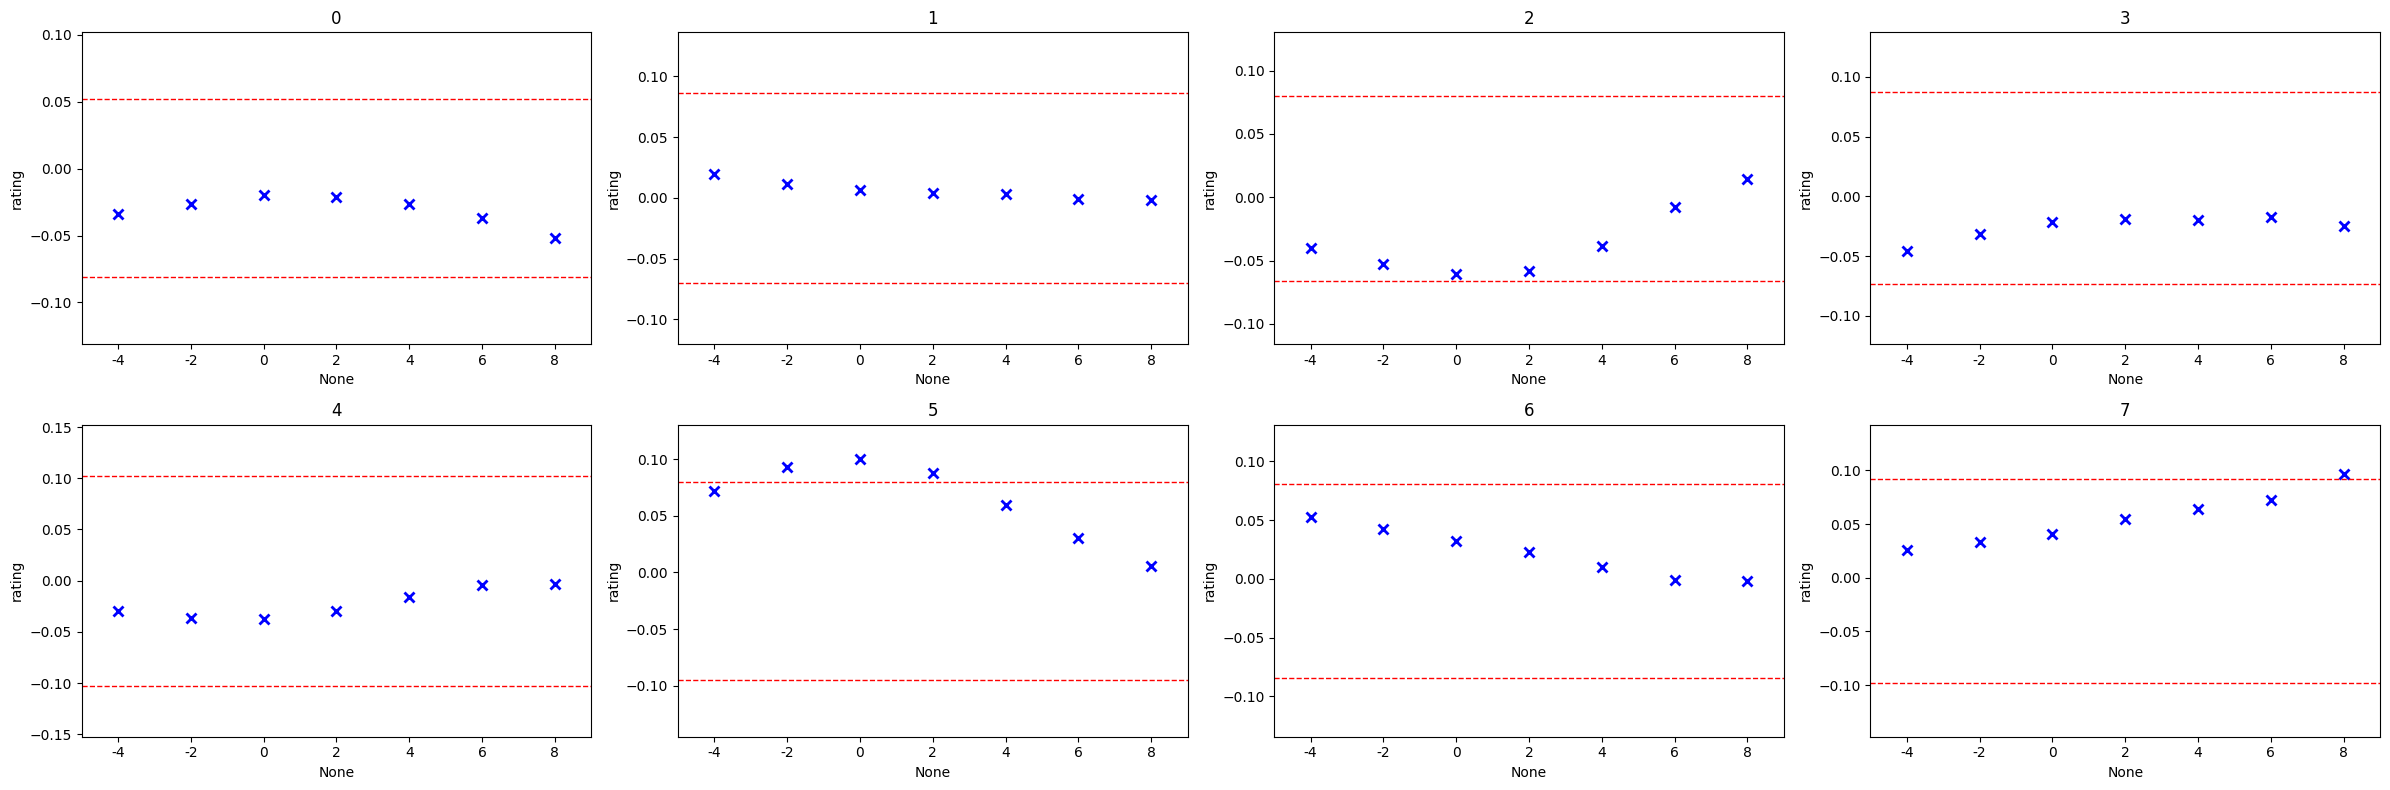

In [48]:
allresults.index=delaylist
fig, axes = plt.subplots(2, 4, figsize=(24, 8))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(statelist):
    sns.pointplot(x=allresults.index.astype(int),y=allresults[col],color='b',ax=axes[i],linestyle='none',markers='x')
    axes[i].set_title(col)  # Set title to column name
    axes[i].set_ylim(cibounds.loc[col,'lower']-.05, cibounds.loc[col,'upper']+.05)  # Set common y-axis limits
    axes[i].set(ylabel='rating')
    axes[i].axhline(y=cibounds.loc[col,'lower'], color='red', linestyle='--', linewidth=1)  # Add horizontal line at y=0.3
    axes[i].axhline(y=cibounds.loc[col,'upper'], color='red', linestyle='--', linewidth=1)  # Add horizontal line at y=0.7
    
for j in range(len(allresults.columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()
plt.close()


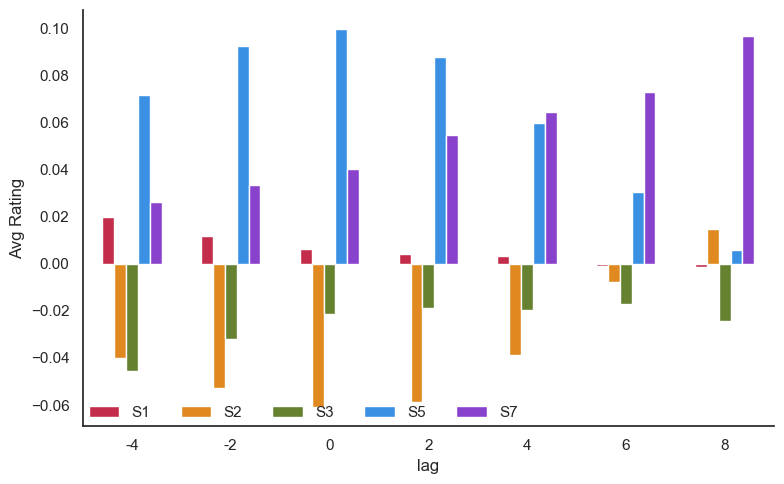

In [52]:

allresults.rename(columns=dict([(s,'S'+s) for s in selectstates]),inplace=True)
newstates=['S'+s for s in selectstates]
tmp=allresults[newstates+['lag']].melt(value_vars=newstates,id_vars='lag',value_name='Avg Rating',var_name='state')
sns.set(font_scale=1)
sns.set_style('white')
fig,ax=plt.subplots(1,figsize=(8,5))
#sns.barplot(data=tmp,x='lag',y='Correlation w/ rating',hue='state', width=0.6,ax=ax,palette=custom_colors)
sns.barplot(data=tmp,x='lag',y='Avg Rating',hue='state', width=0.6,ax=ax,palette=custom_colors)

plt.legend(loc=(.0,.0), ncol=len(selectstates),framealpha=0)

sns.despine()
plt.tight_layout()
plt.show()
plt.close()

# rating validation with GPT

In [70]:
def extractSentenceRating(textDF,ratingvalues,shift=RATING_SHIFT):
    shifted = ratingvalues.set_axis(ratingvalues.index-shift)
    shifted=pd.concat([shifted,pd.Series(shifted.iloc[-1],index=range(shifted.index[-1]+1,MAX_TIME+2))]) 
    return shifted.loc[textDF['end']].values

def processTiming(textDF,keepcol=[]):
    textDF['begin']=(textDF['begin_timestamp']*10).astype(int)
    textDF['end']=(textDF['end_timestamp']*10).astype(int) #move from seconds to 100 ms to be in the same unit as dynamic rating
    textDF['next']=(textDF['begin'].shift(-1).fillna(4200)).astype(int) #the start of the next line
    textDF['dur']=(textDF['next']-textDF['end']).shift()/10 #in seconds break duration from the previous!
    dropcols=['sentblock','perplexity','bertDist','bertDistBlock','isAT','begin_timestamp','end_timestamp']
    dropcols=[x for x in dropcols if x not in keepcol]
    return textDF.drop(columns=dropcols)

In [64]:
ratingname='IntExt'
ratings={}
ratingdata=pd.read_excel(ratingfolder+'ACHIEVE1_'+ratingname+'.xlsx',sheet_name=None)
raters=list(ratingdata.keys())
ratingdata[raters[0]].columns=['0'+x if len(x)==6 else x for x in ratingdata[raters[0]].columns]
ratingdata[raters[1]].columns=['0'+x if len(x)==6 else x for x in ratingdata[raters[1]].columns]

tmp=ratingdata[raters[0]].merge(ratingdata[raters[1]],how='inner',left_index=True,right_index=True,suffixes=['','-2'])
uniquecol=set([x.split('-')[0] for x in tmp.columns])
for c in uniquecol:
    if c+'-2' in tmp.columns:
        tmp[c]=tmp[[c,c+'-2']].mean(axis=1)
ratingdata['avg']=tmp[list(uniquecol)]


In [72]:
normQ=False
verbose=True
min_end_time=380 #the very last timestamp should exeed this number, in seconds
allshiftedDF=[]
for shift in [0,10,20,30,40,50,60,70,80,90,100]:#in 100 msec unit for correcting rater time delay
    allresults=[]
    for i,g in decodedTC[(decodedTC['newtask']=='ta')&(decodedTC['time'].isin(timelist))].groupby(['subid','task']):
        subid=i[0].split('-')[1]
        task=i[1]
        if len(subid)<2:subid='0'+subid
        if subid in excludeSubjects:continue
        col=subid+task.replace('ta','_run') #col is used to query the dynamic rating column
        if col not in ratingdata['avg'].columns:continue
        
        try:
            textDF=pd.read_csv(textFolder+subid+'_'+task.upper()+'.csv',index_col=None)
        except:
            #print('cannot find EB file: '+subid+task)
            continue
        if textDF['end_timestamp'].max()<min_end_time:
            print('incomplete, drop '+i)
            continue
        ratingvalue = modifyratings(textDF,ratingdata['avg'][col])
        if ratingvalue.max()-ratingvalue.min()<MIN_VARIABILITY:continue
            
        textDF=textDF[textDF['begin_timestamp']>initialcutoff]
        textDF=processTiming(textDF,keepcol=['begin_timestamp','end_timestamp','IntExt_gpt'])
        #merge in dynamic ratings
        for rater in raters+['avg']:
            if col in ratingdata[rater].columns:
                #ratingvalue=ratings[ratingname][col]
                #ratingvalue = modifyratings(textDF,shifted)
                #textDF[ratingname+'_'+rater]=ratingvalue.loc[textDF['end']].values #rating for the current line
                textDF[ratingname+'_'+rater]=extractSentenceRating(textDF,ratingdata[rater][col],shift)
            else:
                #print('missing rating: ',rater,', session,',col)
                textDF[ratingname+'_'+rater]=np.nan
        corrdf=np.round(textDF[['IntExt_GPT']+['IntExt_'+r for r in raters+['avg']]].corr(),3)
        allresults.append([col,corrdf.iloc[0,3],corrdf.iloc[0,1],corrdf.iloc[0,2],corrdf.iloc[1,2]])
    allshiftedDF.append(pd.DataFrame(allresults,columns=['session','gpt-avg','gpt-r1','gpt-r2','r1-r2']))

In [80]:
#correlation between two raters
allshiftedDF[0][['r1-r2']].describe()

,r1-r2
count,44.000000
mean,0.539023
std,0.242187
min,-0.390000
25%,0.454250
50%,0.559500
75%,0.699250
max,0.927000


In [74]:
#gpt-human correlation at different shifts
tmp=pd.DataFrame([[df.loc[df['session']==s,'gpt-avg'].values[0] for df in allshiftedDF] for s in allshiftedDF[0]['session'].unique()])
tmp.columns=range(11)
tmp.index=allshiftedDF[0]['session'].unique()
tmp.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,0.448410,0.486541,0.513197,0.533361,0.547639,0.547180,0.547283,0.536000,0.521650,0.510933,0.496483
std,0.249797,0.250167,0.242692,0.236200,0.229456,0.231636,0.221042,0.221351,0.216377,0.218253,0.214600
min,-0.103000,-0.099000,-0.099000,-0.098000,-0.094000,-0.100000,-0.100000,-0.100000,-0.100000,-0.099000,-0.107000
25%,0.269000,0.280000,0.363000,0.402000,0.437000,0.436000,0.461000,0.431750,0.428000,0.413250,0.407750
50%,0.500000,0.534000,0.536000,0.574000,0.580000,0.593000,0.593000,0.594500,0.575500,0.571000,0.534000
75%,0.635000,0.681000,0.689000,0.689000,0.714000,0.699000,0.700750,0.679000,0.653250,0.646250,0.637750
max,0.843000,0.903000,0.888000,0.884000,0.893000,0.901000,0.908000,0.907000,0.902000,0.894000,0.886000


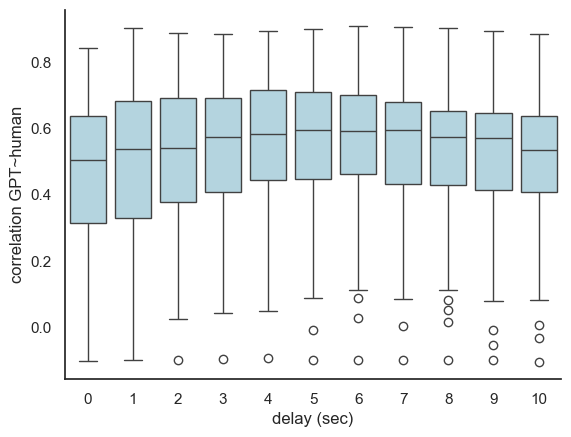

In [76]:
ax=sns.boxplot(data=tmp.dropna(),color='lightblue')
#sns.barplot(data=tmp.dropna(),errorbar=('se',1))
ax.set(xlabel='delay (sec)',ylabel='correlation GPT~human')
sns.despine()
plt.show()
plt.close()

# Discrete mixed effect model

In [ ]:
ratingdata=pd.read_excel(ratingfolder+'ACHIEVE1_IntExt.xlsx',sheet_name=None)
raters=list(ratingdata.keys())
#some columns is 1-run1 some are 01-run1 make that uniform
ratingdata[raters[0]].columns=['0'+x if len(x)==6 else x for x in ratingdata[raters[0]].columns]
ratingdata[raters[1]].columns=['0'+x if len(x)==6 else x for x in ratingdata[raters[1]].columns]
tmp=ratingdata[raters[0]].merge(ratingdata[raters[1]],how='inner',left_index=True,right_index=True,suffixes=['','-2'])
uniquecol=set([x.split('-')[0] for x in tmp.columns])
for c in uniquecol:
    if c+'-2' in tmp.columns:
        tmp[c]=tmp[[c,c+'-2']].mean(axis=1)
ratings=tmp[list(uniquecol)]

In [ ]:
decodedTC=decodedTC.merge(participants[['subid','Age Group']],how='left',left_on='subid',right_on='subid')

In [249]:
BOLD_Delay=2

In [110]:
# align data at sentence level
# aggregate between sentence features, and within sentence features
verbose=False
allresults=pd.DataFrame()
preChangeWindow=3 #3 second window before the next sentence start
min_end_time=380 #the very last timestamp should exeed this number, in seconds
normQ=True
for i,g in decodedTC[(decodedTC['newtask']=='ta')&(decodedTC['time'].isin(timelist))].groupby(['subid','task']):
    subid=i[0].split('-')[1]
    task=i[1]
    agegroup=g['Age Group'].values[0]
    if len(subid)<2:subid='0'+subid
    if subid in excludeSubjects:continue
    col=subid+task.replace('ta','_run') #col is used to query the dynamic rating column
    try:
        textDF=pd.read_csv(textFolder+subid+'_'+task.upper()+'.csv',index_col=None)
    except:
        print('cannot find EB file: '+subid+task)
        continue
    if textDF['end_timestamp'].max()<min_end_time:
        print('incomplete, drop '+i)
    textDF=processTiming(textDF,keepcol=['perplexity','IntExt_GPT','begin_timestamp','end_timestamp'])
    #merge in brainstates
    brainstate=g[statelist+['time','state']].copy()
    brainstate['timestamp']=((g['time']-BOLD_Delay)*10).astype(int)
    brainstate.set_index('timestamp',inplace=True)
   
    brainstate.drop(columns=['time'],inplace=True)
    brainstate=brainstate.loc[initialcutoff*10:]
    
    newindex=list(range(initialcutoff*10,4201))
    #interpolating the brain state values
    brainstate=brainstate.reindex(np.sort(list(set(list(brainstate.index)+newindex)))).interpolate(method='linear').loc[newindex]
    maxtime=brainstate.index.max()
    #merge in dynamic ratings
    if col in ratings.columns:
        ratingvalue = modifyratings(textDF,ratings[col])
        if ratingvalue.max()-ratingvalue.min()>=MIN_VARIABILITY:
            if normQ:
                ratingvalue=safeNorm(ratingvalue)
            textDF[ratingname]=ratingvalue.loc[textDF['end']].values
            textDF[ratingname+'_diff']=textDF[ratingname].diff().shift(-1) #diff to the next line
        else:
            print(f'{subid}-{task}: {ratingname} range too small')
            textDF[ratingname]=np.nan
            textDF[ratingname+'_diff']=np.nan
    else:
        print('missing rating: ',ratingname,', session,',col)
        textDF[ratingname]=np.nan
    if normQ:
        textDF['perplexity']=safeNorm(textDF['perplexity'])
    textDF['perplexity_next']=textDF['perplexity'].shift(-1)
    if textDF['IntExt_GPT'].max()-textDF['IntExt_GPT'].min()>=MIN_VARIABILITY:
        textDF['IntExt_GPT_diff']=textDF['IntExt_GPT'].diff().shift(-1)
    else:
        textDF['IntExt_GPT_diff']=np.nan
        textDF['IntExt_GPT']=np.nan
    textDF=textDF[textDF['begin_timestamp']>initialcutoff]
    for j,df in textDF.iterrows():
        tmp=brainstate.loc[df['begin']:df['end'],statelist].mean()
        tmp['senbreak']=False
        tmp['session']=subid+'_'+task
        tmp['Age']=agegroup
        tmp['wordcnt']=df['wordcnt']
        tmp['dur']=df['end']-df['begin'] #shift one row, becasue the original dur is the break time from previous line
        for rating in ['IntExt','IntExt_GPT']:
            tmp[rating]=df[rating] #these are changes from the current line to the next
            tmp[rating+'_diff']=df[rating+'_diff'] #these are changes from the current line to the next
        tmp['perplexity']=df['perplexity']
        allresults=pd.concat([allresults,pd.DataFrame(tmp).T],ignore_index=True)
        if j<textDF.index.max():
            tmp=brainstate.loc[(df['next']-preChangeWindow*10):df['next'],statelist].mean() 
            for rating in ['IntExt','IntExt_GPT']:
                tmp[rating+'_diff']=df[rating+'_diff'] #these are changes from the current line to the next
                tmp[rating]=df[rating] #these are changes from the current line to the next
            tmp['perplexity']=df['perplexity_next']  #perplexity for the next line when looking at sentence break
            tmp['senbreak']=True
            tmp['session']=subid+'_'+task
            tmp['Age']=agegroup
            tmp['wordcnt']=df['wordcnt']
            tmp['dur']=textDF.loc[j+1]['dur'] #shift one row, becasue the original dur is the break time from previous line
            allresults=pd.concat([allresults,pd.DataFrame(tmp).T],ignore_index=True)
allresults[['senbreak']]=allresults[['senbreak']].astype(bool)
allresults[statelist]=allresults[statelist].astype(float)

cannot find EB file: 01ta2
cannot find EB file: 15ta1
cannot find EB file: 15ta2
cannot find EB file: 30ta1
cannot find EB file: 30ta2
cannot find EB file: 39ta1
cannot find EB file: 39ta2
cannot find EB file: 41ta1
cannot find EB file: 42ta1
cannot find EB file: 52ta1
cannot find EB file: 52ta2
cannot find EB file: 53ta1
cannot find EB file: 54ta1
cannot find EB file: 54ta2
cannot find EB file: 64ta1
cannot find EB file: 74ta1
cannot find EB file: 74ta2
cannot find EB file: 78ta2


In [112]:
#brain states durng sentence associated with ratings
for rating in ['IntExt','IntExt_GPT','perplexity']:
    print(rating)
    tmp=allresults.loc[~allresults['senbreak'],['Age','session',rating,'dur']+statelist].dropna()
    tmp[statelist+[rating,'dur']]=tmp[statelist+[rating,'dur']].astype(float)
    tmp.rename(columns=dict([(s,'S'+s) for s in statelist]),inplace=True)
    model = smf.mixedlm(f"{rating} ~ S1+S2+S3+S5+S7+Age+dur", tmp, groups=tmp["session"])
    result = model.fit()
    var_fixed = result.fittedvalues.var()  # Variance of fixed effects predictions
    var_random = result.cov_re.iloc[0, 0]  # Variance of random effects
    var_resid = result.scale 
    marginal_r2 = var_fixed / (var_fixed + var_random + var_resid)
    conditional_r2 = (var_fixed + var_random) / (var_fixed + var_random + var_resid)
    print(f"Marginal R²: {marginal_r2}")
    print(f"Conditional R²: {conditional_r2}")
    print(result.summary())
 

IntExt
Marginal R²: 0.021402459577647737
Conditional R²: 0.0411515688009193
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: IntExt    
No. Observations: 3656    Method:             REML      
No. Groups:       71      Scale:              0.6869    
Min. group size:  15      Log-Likelihood:     -4543.8991
Max. group size:  147     Converged:          Yes       
Mean group size:  51.5                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.059    0.039  1.532 0.125 -0.016  0.135
Age[T.YA]     -0.099    0.042 -2.379 0.017 -0.181 -0.017
S1             0.096    0.058  1.651 0.099 -0.018  0.210
S2             0.002    0.057  0.037 0.971 -0.109  0.113
S3             0.049    0.068  0.712 0.476 -0.085  0.183
S5             0.231    0.067  3.439 0.001  0.099  0.362
S7             0.078  

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


Marginal R²: 0.16237088678141656
Conditional R²: 0.2776372006581444
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: IntExt_GPT
No. Observations: 3497    Method:             REML      
No. Groups:       67      Scale:              0.1099    
Min. group size:  15      Log-Likelihood:     -1196.4937
Max. group size:  147     Converged:          Yes       
Mean group size:  52.2                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.806    0.026 30.678 0.000  0.755  0.857
Age[T.YA]     -0.131    0.035 -3.751 0.000 -0.200 -0.063
S1             0.046    0.024  1.911 0.056 -0.001  0.094
S2            -0.024    0.024 -0.999 0.318 -0.070  0.023
S3            -0.032    0.028 -1.118 0.263 -0.088  0.024
S5             0.115    0.028  4.062 0.000  0.059  0.170
S7             0.032    0.030 

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


Marginal R²: 0.012792554331388218
Conditional R²: 0.012793874310572464
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: perplexity
No. Observations: 3656    Method:             REML      
No. Groups:       71      Scale:              0.9145    
Min. group size:  15      Log-Likelihood:     -5041.8303
Max. group size:  147     Converged:          Yes       
Mean group size:  51.5                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.189    0.098 -1.939 0.053 -0.381  0.002
Age[T.YA]     -0.023    0.051 -0.446 0.655 -0.123  0.077
S1             0.026    0.065  0.399 0.690 -0.101  0.152
S2            -0.013    0.063 -0.208 0.835 -0.137  0.111
S3             0.144    0.095  1.518 0.129 -0.042  0.331
S5             0.019    0.101  0.191 0.848 -0.178  0.216
S7             0.280    0.0

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [114]:
#brain state at transition is associated with the change of thoughts
for rating in ['IntExt_diff','IntExt_GPT_diff','perplexity']:
    print(rating)
    tmp=allresults.loc[allresults['senbreak'],['Age','session',rating,'dur']+statelist].dropna()
    tmp[statelist+[rating,'dur']]=tmp[statelist+[rating,'dur']].astype(float)
    tmp.rename(columns=dict([(s,'S'+s) for s in statelist]),inplace=True)
    model = smf.mixedlm(f"{rating} ~ S1+S2+S3+S5+S7+dur+Age", tmp, groups=tmp["session"])
    #for hmm8_seed45 young
    #model = smf.mixedlm(f"{rating} ~ S1+S2+S3+S5+S6+S7+dur", tmp, groups=tmp["session"])
    #for hmm10_seed120
    #model = smf.mixedlm(f"{rating} ~ S0+S1+S2+S3+S6+S7+S9+Age+dur", tmp, groups=tmp["session"])
    
    #for hmm6_seed3
    #model = smf.mixedlm(f"{rating} ~ S1+S3+S4+S5+Age+dur", tmp, groups=tmp["session"])

    
    if rating[:10]=='transition':
        model = smf.mixedlm(f"{rating} ~ S1+S2+S3+S5+S7+dur+Age", tmp, groups=tmp["session"],family=smf.families.Binomial())
    result = model.fit()
    var_fixed = result.fittedvalues.var()  # Variance of fixed effects predictions
    var_random = result.cov_re.iloc[0, 0]  # Variance of random effects
    var_resid = result.scale 
    marginal_r2 = var_fixed / (var_fixed + var_random + var_resid)
    conditional_r2 = (var_fixed + var_random) / (var_fixed + var_random + var_resid)
    print(f"Marginal R²: {marginal_r2}")
    print(f"Conditional R²: {conditional_r2}")
    print(result.summary())

IntExt_diff


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, Converge

Marginal R²: 0.0019319647184893537
Conditional R²: 0.0019319647184893537
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: IntExt_diff
No. Observations: 3585    Method:             REML       
No. Groups:       71      Scale:              0.3035     
Min. group size:  14      Log-Likelihood:     -2969.0906 
Max. group size:  146     Converged:          Yes        
Mean group size:  50.5                                   
----------------------------------------------------------
           Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept   0.000     0.017   0.000  1.000  -0.034   0.034
Age[T.YA]  -0.000     0.020  -0.000  1.000  -0.038   0.038
S1         -0.007     0.035  -0.192  0.848  -0.076   0.063
S2         -0.046     0.035  -1.331  0.183  -0.114   0.022
S3         -0.035     0.041  -0.842  0.400  -0.116   0.046
S5         -0.015     0.041  -0.359  0.720  -0.096   0.066


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, Converge

Marginal R²: 0.0018608885681714424
Conditional R²: 0.0018608885681714424
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: IntExt_GPT_diff
No. Observations: 3430    Method:             REML           
No. Groups:       67      Scale:              0.0958         
Min. group size:  14      Log-Likelihood:     -868.7103      
Max. group size:  146     Converged:          Yes            
Mean group size:  51.2                                       
--------------------------------------------------------------
               Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------
Intercept       0.000     0.010   0.000  1.000  -0.020   0.020
Age[T.YA]       0.000     0.011   0.000  1.000  -0.022   0.022
S1              0.026     0.020   1.287  0.198  -0.014   0.066
S2             -0.005     0.020  -0.237  0.813  -0.044   0.035
S3             -0.031     0.024  -1.295  0.195  -0.077   0.016
S

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, Converge

# Control analysis -- auditory

In [134]:
from nilearn import datasets
mintimebetween=12 #minimum seconds between two timestamps that mentioned the keyword
sentenceEnds=['.','!','?']
def findKeywords(textDF,keywords,verbose=False,sentencestart=False):
    keywordtimestamps=[]
    lasttimestamp=-15
    keywordsfound=[]
    sentenceStartTime=0
    for i,g in textDF.iterrows():
        pattern = r'\b(' + '|'.join(map(re.escape, keywords)) + r')\b'
        # Search for the first occurrence
        thistext=g['Word']
        match = re.search(pattern, thistext)
        if thistext[-1] in sentenceEnds:
            sentenceStartTime=g['Start']
        if match:
            if sentencestart:
                thistimestamp=sentenceStartTime
            else:
                thistimestamp=g['Start']
            if len(keywordtimestamps)>0:
                if thistimestamp-lasttimestamp<mintimebetween:
                    if lasttimestamp==keywordtimestamps[-1]:
                        #too close, pop out the last one
                        keywordtimestamps=keywordtimestamps[:-1]
                        keywordsfound=keywordsfound[:-1]
                else:
                    keywordtimestamps.append(thistimestamp)
                    keywordsfound.append(thistext[match.start():match.end()])
            else:
                keywordtimestamps.append(thistimestamp)
                keywordsfound.append(thistext[match.start():match.end()])
            lasttimestamp=thistimestamp
    return keywordtimestamps,keywordsfound

In [122]:
timestampFolder='/Users/yuhuayu/Documents/spontaneous thought/ACHIEVE1/data processing/timestamp_byword/'
schaeferDataFolder=projectfolder+'/postprocessing4/extract/schaefer400/'

In [128]:
mask_img=datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=2)
atlas_filename = mask_img.maps
yeo_labels = mask_img.labels 
labels = [label.decode("utf-8") if isinstance(label, bytes) else label for label in yeo_labels]

In [130]:
currentlabels=[x for x in labels if 'SomMotB_Aud_2' in x]
current_mask = np.array([1 if s in currentlabels else 0 for s in labels])
print(currentlabels)

['17Networks_LH_SomMotB_Aud_2', '17Networks_RH_SomMotB_Aud_2']


In [138]:
keywords=['noise','sound','jackhammer','jackhammers','hammering','loud']
excludestart=0

allresults=pd.DataFrame()
mintime=-10
maxtime=12
reindexlist=list(np.linspace(mintime,maxtime,45))
allkeywordsfound=[]
for filename in os.listdir(timestampFolder):
    if filename.split('.')[-1]=='csv':
        textDF=pd.read_csv(timestampFolder+filename,index_col=None)
        keywordstime,keywordsfound = findKeywords(textDF,keywords)
        if len(keywordstime)==0:continue
        print(filename,keywordsfound)
        sub=filename.split('_')[0]
        
        task=filename.split('.')[0].split('_')[1].lower()
        if len(sub)<2:sub='0'+sub
        if sub in excludeSubjects:continue

    
        datafile=schaeferDataFolder+sub+'_'+task+'.csv'
        if not os.path.isfile(datafile):
            print('cannot find '+datafile)
            continue
        subdata=pd.read_csv(datafile,index_col=None)
        subdata=subdata.iloc[excludeHead:excludeTail]
        values=np.dot(subdata.values,current_mask)/np.sum(current_mask)
        boldDF=pd.DataFrame({'time':timelist,'bold':values})
        allkeywordsfound=allkeywordsfound+list(keywordsfound)
        for time in keywordstime:
            boldDF['timediff']=boldDF['time']-time
            tmp=boldDF.loc[(mintime-.4<boldDF['timediff'])&(boldDF['timediff']<maxtime+.4),['timediff','bold']]
            tmp['session']=sub+'_'+task
            allresults=pd.concat([allresults,tmp],ignore_index=True)
allresults['buckettime']=(np.round(allresults['timediff']/2)*2).astype(int)

58_TA2.csv ['noise']
33_TA1.csv ['noise', 'sound']
41_TA1.csv ['noise']
77_TA2.csv ['sound', 'loud']
58_TA1.csv ['noise']
33_TA2.csv ['noise']
41_TA2.csv ['loud']
51_TA2.csv ['sound']
77_TA1.csv ['sound']
67_TA1.csv ['sound', 'loud']
32_TA2.csv ['loud', 'noise', 'noise']
22_TA2.csv ['noise', 'sound']
cannot find /Users/yuhuayu/Documents/spontaneous thought/ACHIEVE1/BOLD/postprocessing4/extract/schaefer400/22_ta2.csv
66_TA1.csv ['noise']
76_TA1.csv ['noise', 'loud', 'noise']
cannot find /Users/yuhuayu/Documents/spontaneous thought/ACHIEVE1/BOLD/postprocessing4/extract/schaefer400/76_ta1.csv
22_TA1.csv ['noise']
cannot find /Users/yuhuayu/Documents/spontaneous thought/ACHIEVE1/BOLD/postprocessing4/extract/schaefer400/22_ta1.csv
32_TA1.csv ['noise', 'noise']
76_TA2.csv ['loud']
cannot find /Users/yuhuayu/Documents/spontaneous thought/ACHIEVE1/BOLD/postprocessing4/extract/schaefer400/76_ta2.csv
66_TA2.csv ['noise']
42_TA2.csv ['loud']
20_TA1.csv ['loud', 'sound', 'noise']
43_TA1.csv ['nois

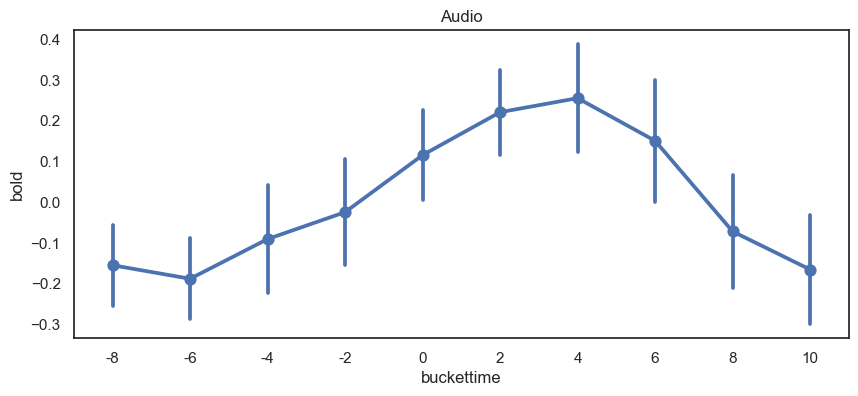

In [140]:
pltdata=allresults.groupby(['buckettime','session']).mean()[['bold']].reset_index()
pltdata=pltdata[(pltdata['buckettime']<12)&(pltdata['buckettime']>-10)]

fig,ax=plt.subplots(1,figsize=(10,4))
sns.pointplot(pltdata.dropna(),x='buckettime',y='bold',errorbar="se")
plt.title('Audio')
plt.show()
plt.close()